In [1]:
import mne, fooof, numpy as np, pandas as pd, os, glob, sys
from IPython.display import display, Markdown
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
projpath="/home/tmorshed/projects/def-johngrif/tmorshed/"

In [3]:
datapath=os.path.join(projpath, 'data', 'nmod')
gitpath=os.path.join(projpath, 'bme1500')
if os.path.exists(datapath) and os.path.exists(gitpath):
    display(Markdown("success"))
else:
    display(Markdown('fix it'))

success

In [4]:
os.chdir(datapath)

In [120]:
def md(input):
    display(Markdown(input))
    
## DATA LOARDERS:

def finder():
    filesDepth5 = glob.glob('*/*/*/*/*')
    dirsDepth5 = filter(lambda f: os.path.isdir(f), filesDepth5)

    markers=np.sort(np.array([os.path.join(datapath, f) for f in filesDepth5 if f.endswith('.pkl')]))
    npzs=np.sort(np.array([os.path.join(datapath, f) for f in filesDepth5 if f.endswith('.npz')]))
    return markers, npzs

def load_to_df(markers, npzs, sno):
    _marker=pd.read_pickle(markers[sno])
    fs=_marker['fs']
    dt=1/fs


    with open(npzs[sno], 'rb') as f:
        _npz=np.load(f)
        _data=_npz.f.arr_0
        f.close()
    del _npz
    _df_data=pd.DataFrame(_data,
                          index=_marker['chNames'])
    _df_data.columns=_df_data.columns*dt

    a=pd.DataFrame(np.zeros((np.shape(_data)[-1]), dtype=str))
    a.index=a.index*dt

    _dfidx = pd.DataFrame([i['type'] for i in _marker['mrk']], index=[i['idx']*dt for i in _marker['mrk']])
    _dfidx=_dfidx.drop(labels=_dfidx.index[0])

    for i in _dfidx.index:
        a.loc[i]=_dfidx.loc[i]

    intdict={"":0,
            "s":1,
            "x":2,
            "na":3}

    for x in intdict:
        a=a.replace(x, int(intdict[x]))
    a=a.T
    a.index=['stim']

    _df_data=pd.concat([_df_data, a])
    _df_data.columns.names=['t']
    _df_data.index.names=['ch']
    return _marker, _df_data

def df_to_mne(_marker, _df_data):
    info = mne.create_info(ch_names=list(_df_data.index), sfreq=_marker['fs'], ch_types=(['eeg']*64)+(['misc']*7)+['stim'])
    info['subject_info']={"id":_marker['patientId']}
    raw=mne.io.RawArray(_df_data,info)
    raw.set_montage('standard_1020')
    return raw

In [116]:
_df_data.index

Index(['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
       'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
       'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7',
       'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4',
       'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4',
       'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'LB1',
       'LB2', 'LT', 'RB1', 'RB2', 'RT', 'Gonio', 'stim'],
      dtype='object', name='ch')

In [6]:
markers, npzs = finder()

In [7]:
_marker, _df_data=load_to_df(markers, npzs, 0)

Plotting stimulations:

,0,1,2,3
0,,s,x,na


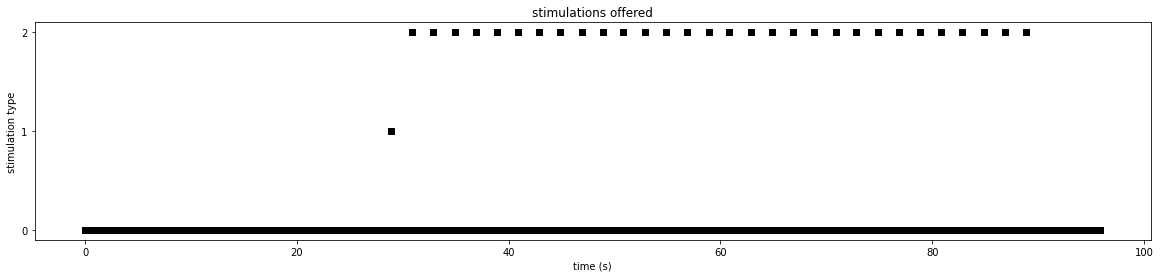

In [52]:
b=np.array(_df_data.iloc[-1,:])
fig,ax=plt.subplots(figsize=(20,4))
plt.scatter(x=_df_data.columns,y=b, color="k", marker="s")
plt.xlabel('time (s)')
plt.title('stimulations offered')
plt.yticks(np.unique(b))
plt.ylabel('stimulation type')
display(pd.DataFrame(["", "s", "x", "na"]).T)
plt.show()

In [53]:
_marker.keys()

dict_keys(['fs', 'patientId', 'clinScore', 'chNames', 'stimInt', 'stimCont', 'stimType', 'hemisphere', 'mrk'])

In [54]:
_df_data.head()

t,0.0000,0.0002,0.0004,0.0006,0.0008,0.0010,0.0012,0.0014,0.0016,0.0018,...,95.8380,95.8382,95.8384,95.8386,95.8388,95.8390,95.8392,95.8394,95.8396,95.8398
ch,,,,,,,,,,,,,,,,,,,,,
Fp1,0.000187,0.000187,0.000186,0.000184,0.000183,0.000183,0.000183,0.000183,0.000182,0.000183,...,0.000014,0.000012,0.000010,0.000011,0.000011,0.000011,0.000011,0.000018,0.000045,0.000053
Fp2,-0.000053,-0.000050,-0.000050,-0.000051,-0.000051,-0.000052,-0.000052,-0.000051,-0.000051,-0.000052,...,-0.000023,-0.000025,-0.000026,-0.000025,-0.000025,-0.000026,-0.000026,-0.000015,0.000025,0.000033
F7,-0.000001,-0.000002,-0.000003,-0.000004,-0.000004,-0.000005,-0.000006,-0.000006,-0.000005,-0.000004,...,0.000005,0.000004,0.000005,0.000006,0.000005,0.000003,0.000002,0.000021,0.000088,0.000086
F3,0.000018,0.000018,0.000015,0.000014,0.000014,0.000015,0.000014,0.000014,0.000015,0.000016,...,0.000021,0.000019,0.000019,0.000019,0.000020,0.000021,0.000022,0.000024,0.000033,0.000036
Fz,-0.000053,-0.000054,-0.000057,-0.000061,-0.000061,-0.000060,-0.000060,-0.000060,-0.000060,-0.000059,...,-0.000018,-0.000020,-0.000019,-0.000018,-0.000017,-0.000017,-0.000016,-0.000005,0.000031,0.000017


In [140]:
raw = df_to_mne(_marker, _df_data)
fs=float(raw.info['sfreq'])
dt=1/fs
raw

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.


<RawArray | 72 x 479200 (95.8 s), ~263.3 MB, data loaded>

31 events found
Event IDs: [1 2]


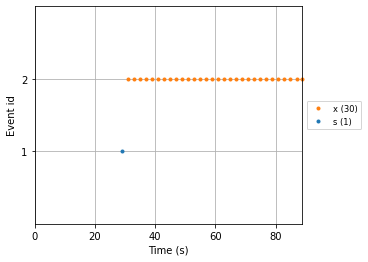

In [143]:
intdict=dict(s=1, x=2)
events=mne.find_events(raw)
fig = mne.viz.plot_events(events, sfreq=fs,first_samp=raw.first_samp, event_id=intdict)

In [ ]:
raw.plot();